# Imports

In [1]:
import numpy as np
import os
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from pandas.plotting import scatter_matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from collections import defaultdict

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import confusion_matrix, f1_score, average_precision_score, classification_report, fbeta_score, accuracy_score
from sklearn.feature_selection import RFECV

from statsmodels.stats.outliers_influence import variance_inflation_factor

import optuna
import statsmodels.api as sm
from boruta import BorutaPy

import custom_map

/Users/dominikmika/PycharmProjects/3.11/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import importlib

importlib.reload(custom_map)

<module 'custom_map' from '/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py'>

# EDA

In [3]:
data = pd.read_csv("healthcare-dataset-stroke-data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
target = "stroke"

categorical_features = data.select_dtypes(['object']).columns.tolist()
numerical_features = data.select_dtypes(['float64', 'int64']).columns.drop('id')
categorical_features.append('stroke')

print(categorical_features, '\n', numerical_features)

data.head()

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'] 
 Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi',
       'stroke'],
      dtype='object')


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


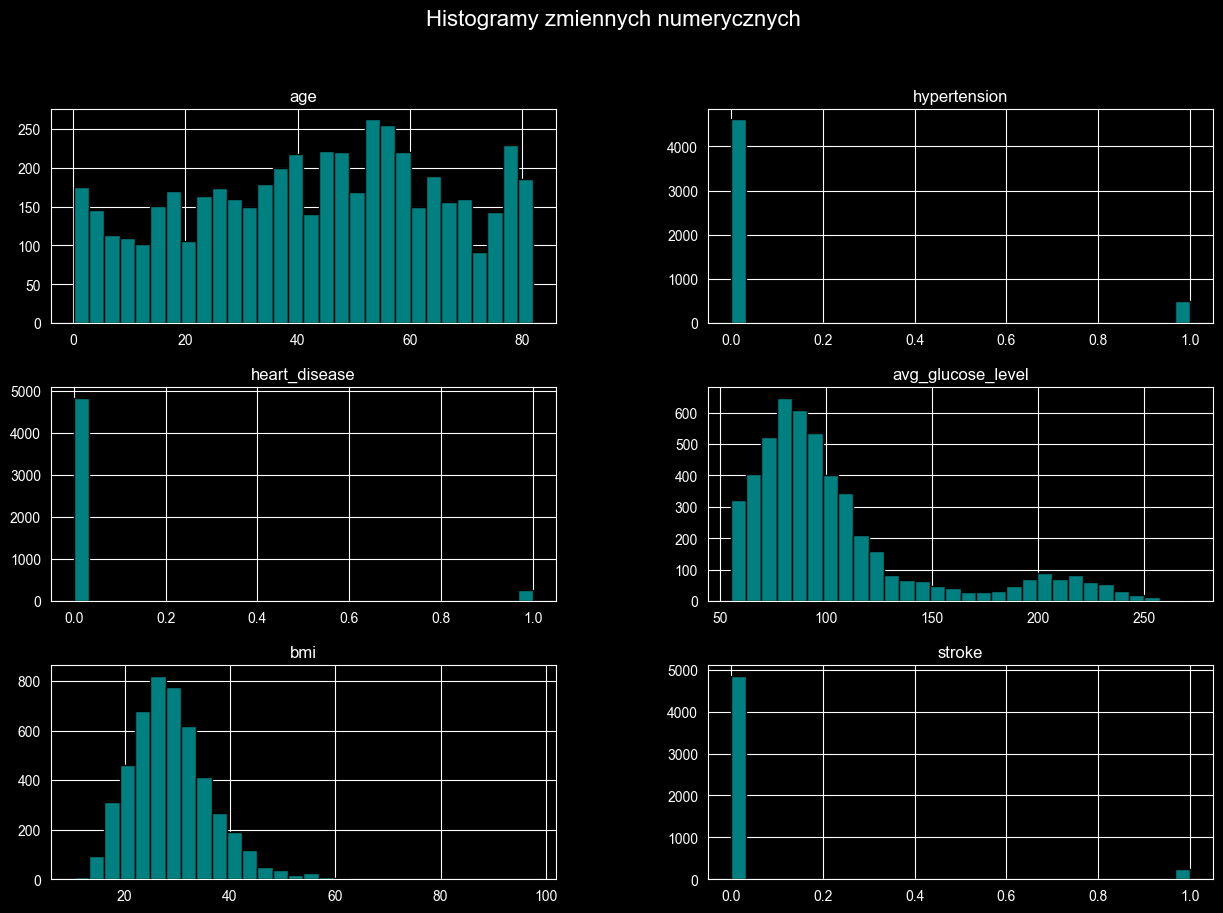

In [5]:
data[numerical_features].hist(bins=30, figsize=(15, 10), color="teal", edgecolor='black')
plt.suptitle("Histogramy zmiennych numerycznych", fontsize=16)
plt.show()

In [6]:
bmi_median = data['bmi'].median()
bmi_mean = data['bmi'].mean()
print(bmi_median, bmi_mean)

data['bmi'] = data['bmi'].fillna(bmi_median)

28.1 28.893236911794666


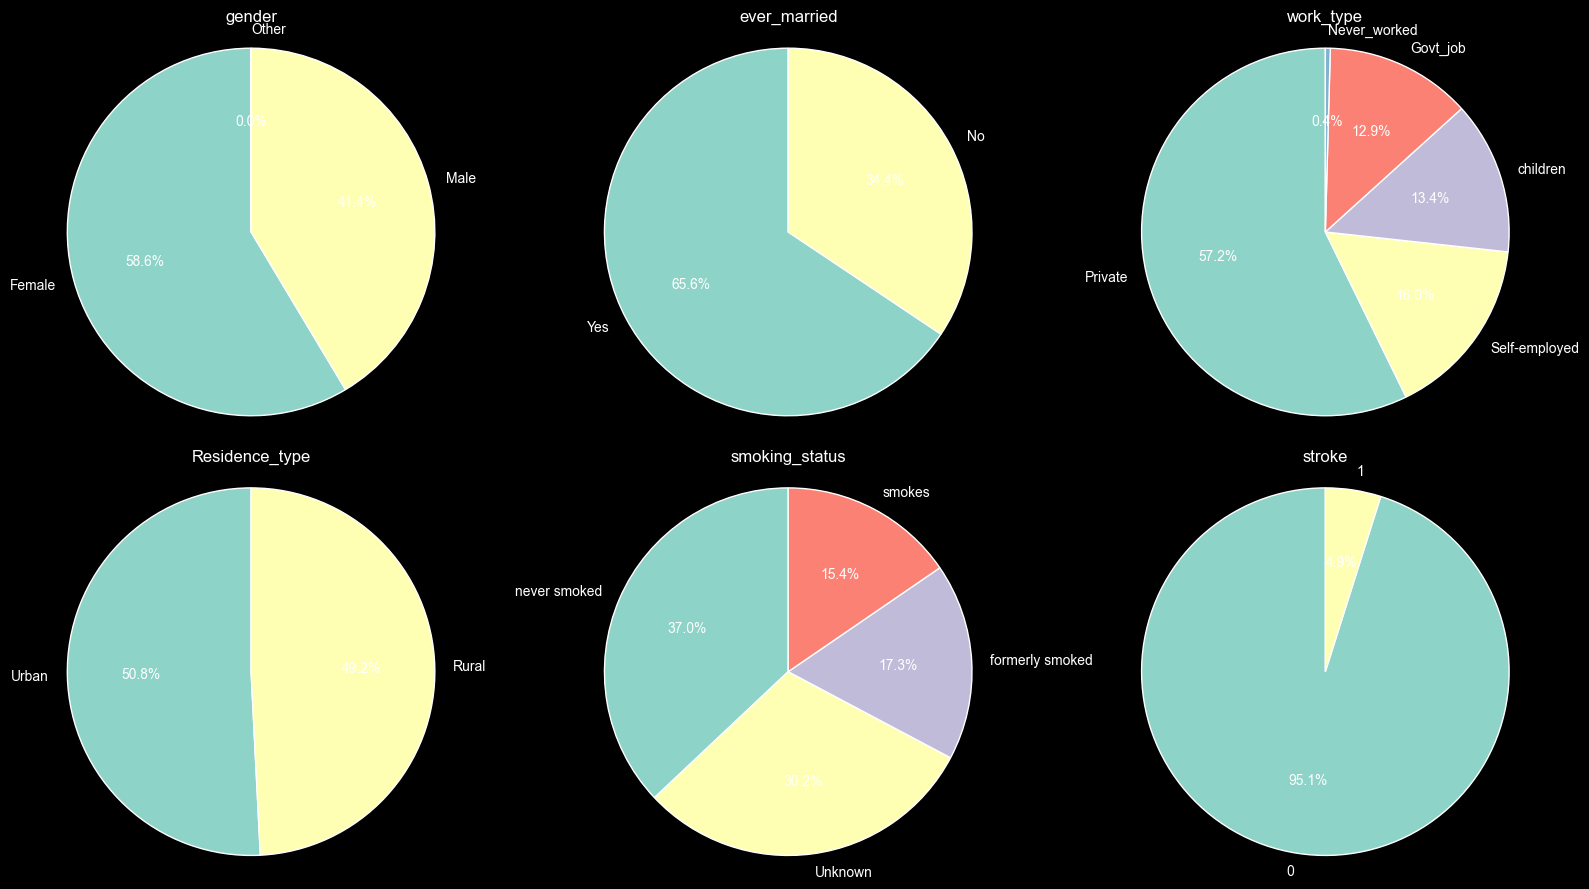

In [7]:
nrows, ncols = 2, 3
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 9))
axes = axes.flat

for ax, col in zip(axes, categorical_features):
    sizes = data[col].value_counts()
    labels = sizes.index.astype(str)

    ax.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    ax.set_title(col)
    ax.axis("equal")

plt.tight_layout()
plt.show()

In [8]:
categorical_features.remove('stroke')
data = pd.get_dummies(data, columns=categorical_features, drop_first=True, dtype=float)
data = data.drop('id', axis=1)

{'name': 'bajon', 'alpha_eff': 0.006666666666666667, 'df': 5108.0, 't_crit': 2.7141624772138377, 'r_crit': 0.03794874842143455, 'steps': 10, 'side_left': 123, 'side_right': 123, 'N': 5110.0}


/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:29: UserWarning: Overwriting the cmap 'bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


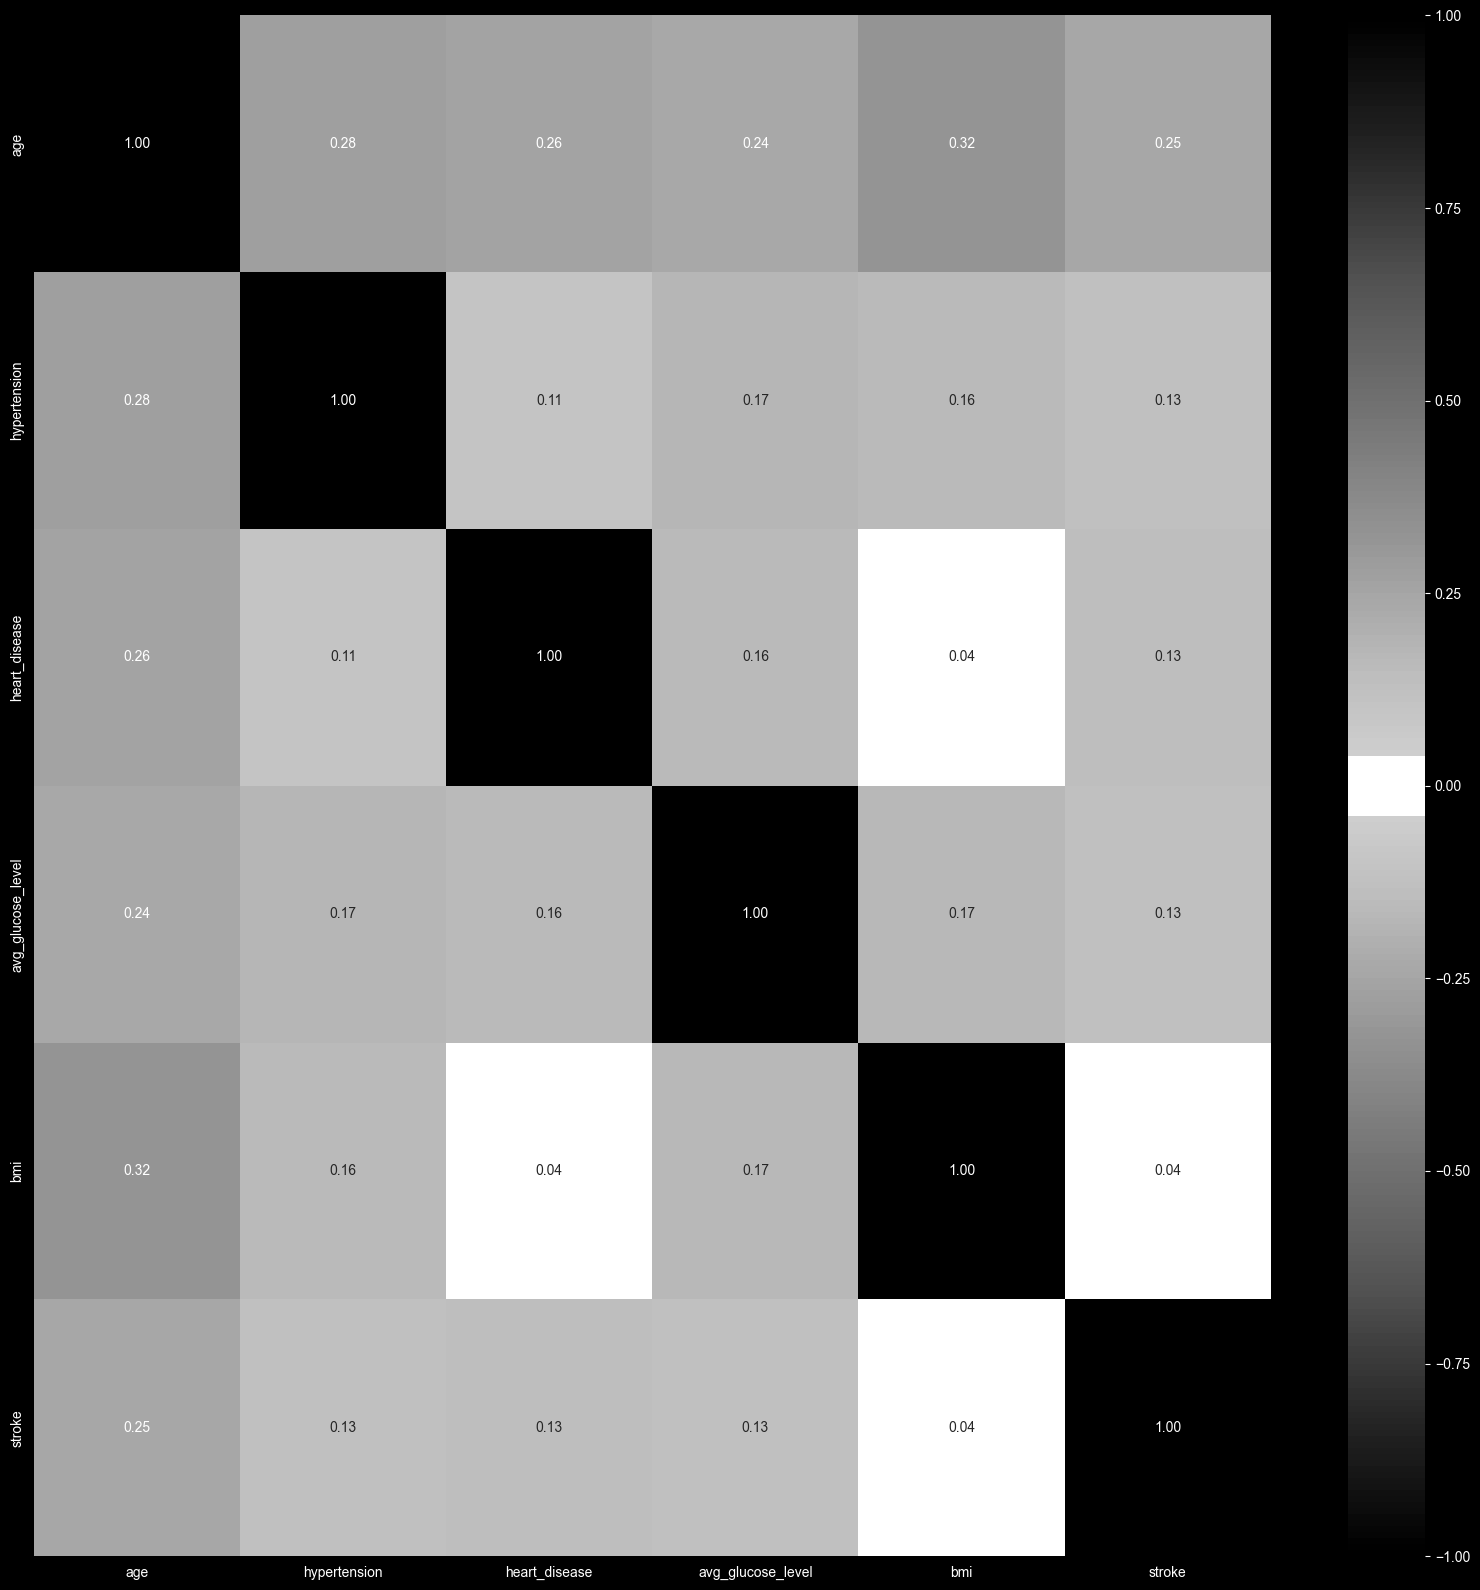

In [9]:
correlation_data = data[numerical_features].corr()

n_features = data[numerical_features].shape[1]
n = data[numerical_features].size/data[numerical_features].shape[1]
custom_map.cmap_pearson(n_features, n, 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="bajon", vmin=-1, vmax=1) #tab20b
plt.tight_layout()
plt.show()

/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:29: UserWarning: Overwriting the cmap 'bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


{'name': 'bajon', 'alpha_eff': 0.006666666666666667, 'df': 5108.0, 't_crit': 2.7141624772138377, 'r_crit': 0.03794874842143455, 'steps': 10, 'side_left': 123, 'side_right': 123, 'N': 5110.0}


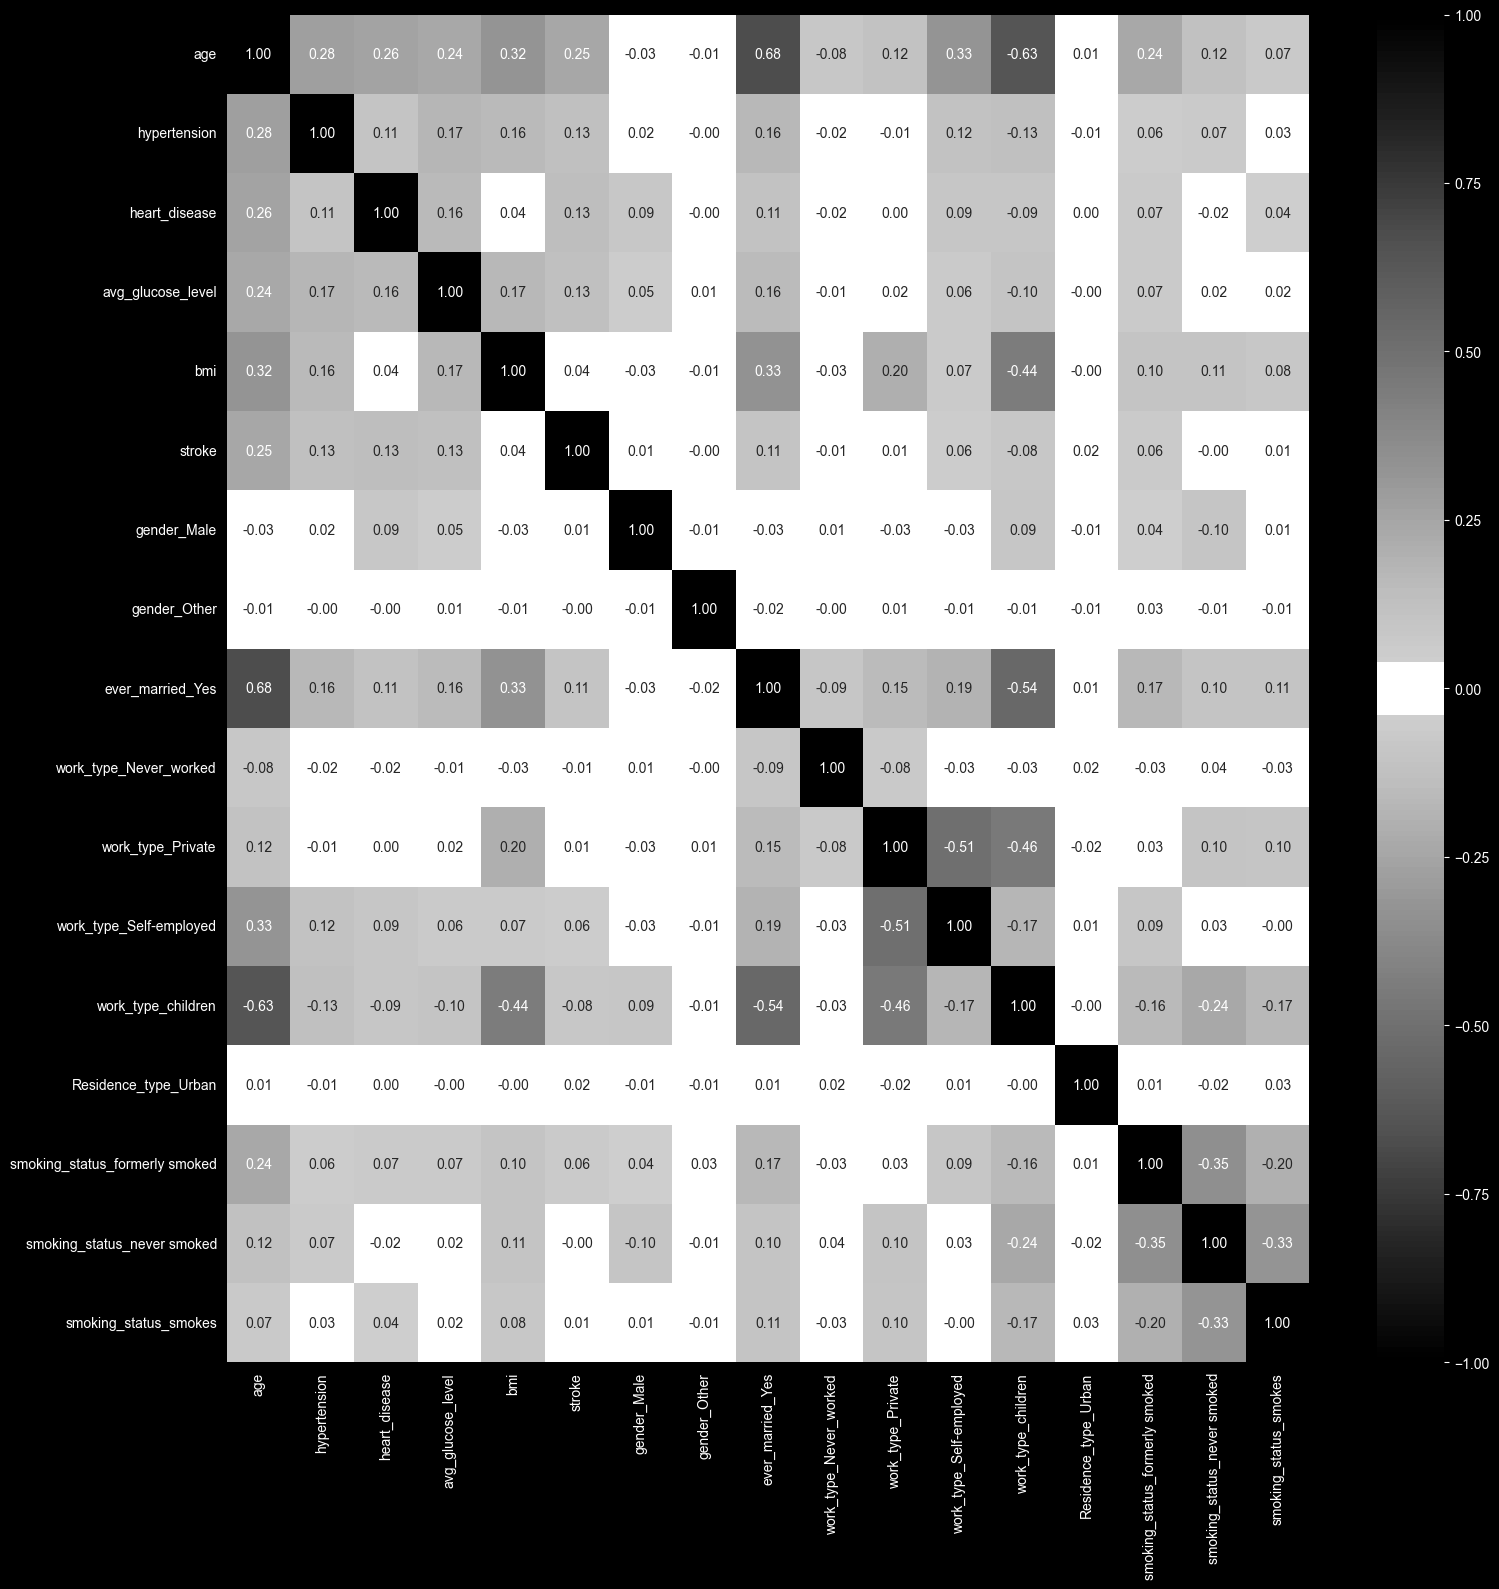

In [10]:
correlation_data = data.corr()

n_features = data[numerical_features].shape[1]
n = data[numerical_features].size/data[numerical_features].shape[1]
custom_map.cmap_pearson(n_features, n, 0.1)
print(custom_map.cmap_pearson(n_features, n, 0.1))

plt.figure(figsize=(16, 16))
sns.heatmap(correlation_data, annot=True, fmt=".2f", cmap="bajon", vmin=-1, vmax=1) #tab20b
plt.tight_layout()
plt.show()

# Feature selection

In [11]:
X = data.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y, shuffle=True)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
rf = RandomForestClassifier(
    n_estimators=500,
    n_jobs=-1,
    class_weight="balanced",
)

boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',   # lub liczba
    max_iter=100,
    alpha=0.05
)

boruta.fit(X_train, y_train)

selected_mask = boruta.support_
selected_features = np.where(selected_mask)[0]
print("Wybrane cechy (indeksy):", selected_features)
print("Ranking:", boruta.ranking_)

Wybrane cechy (indeksy): [0 3 4]
Ranking: [ 1  3  3  1  1  7 14  2 13 10  5 10  7  9  6 12]


In [13]:
selected_indices = np.where(boruta.support_)[0]
boruta_features = X_train.columns[selected_indices].tolist()

boruta_features

['age', 'avg_glucose_level', 'bmi']

In [14]:
corr_features = data.corr()[target].sort_values(ascending=False)
corr_features = corr_features[corr_features > custom_map.cmap_pearson(n_features, n, 0.1)['r_crit']].index.tolist()

corr_features.remove('stroke')
corr_features

/Users/dominikmika/PycharmProjects/Ridge-hillclimbing/custom_map.py:29: UserWarning: Overwriting the cmap 'bajon' that was already in the registry.
  mpl.colormaps.register(my_cmap, force=True)


['age',
 'heart_disease',
 'avg_glucose_level',
 'hypertension',
 'ever_married_Yes',
 'smoking_status_formerly smoked',
 'work_type_Self-employed']

In [15]:
data[corr_features].head()

,age,heart_disease,avg_glucose_level,hypertension,ever_married_Yes,smoking_status_formerly smoked,work_type_Self-employed
0,67.0,1,228.69,0,1.0,1.0,0.0
1,61.0,0,202.21,0,1.0,0.0,1.0
2,80.0,1,105.92,0,1.0,0.0,0.0
3,49.0,0,171.23,0,1.0,0.0,0.0
4,79.0,0,174.12,1,1.0,0.0,1.0


In [16]:
X_chosen = data[corr_features].copy()
X_scaled = scaler.fit_transform(X_chosen)

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=20
)

clusters = kmeans.fit_predict(X_scaled)
X_chosen["cluster"] = clusters

X_chosen["cluster"].describe()

count    5110.000000
mean        0.429159
std         0.594200
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: cluster, dtype: float64

In [17]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 4088 entries, 3449 to 3711
Series name: stroke
Non-Null Count  Dtype
--------------  -----
4088 non-null   int64
dtypes: int64(1)
memory usage: 63.9 KB


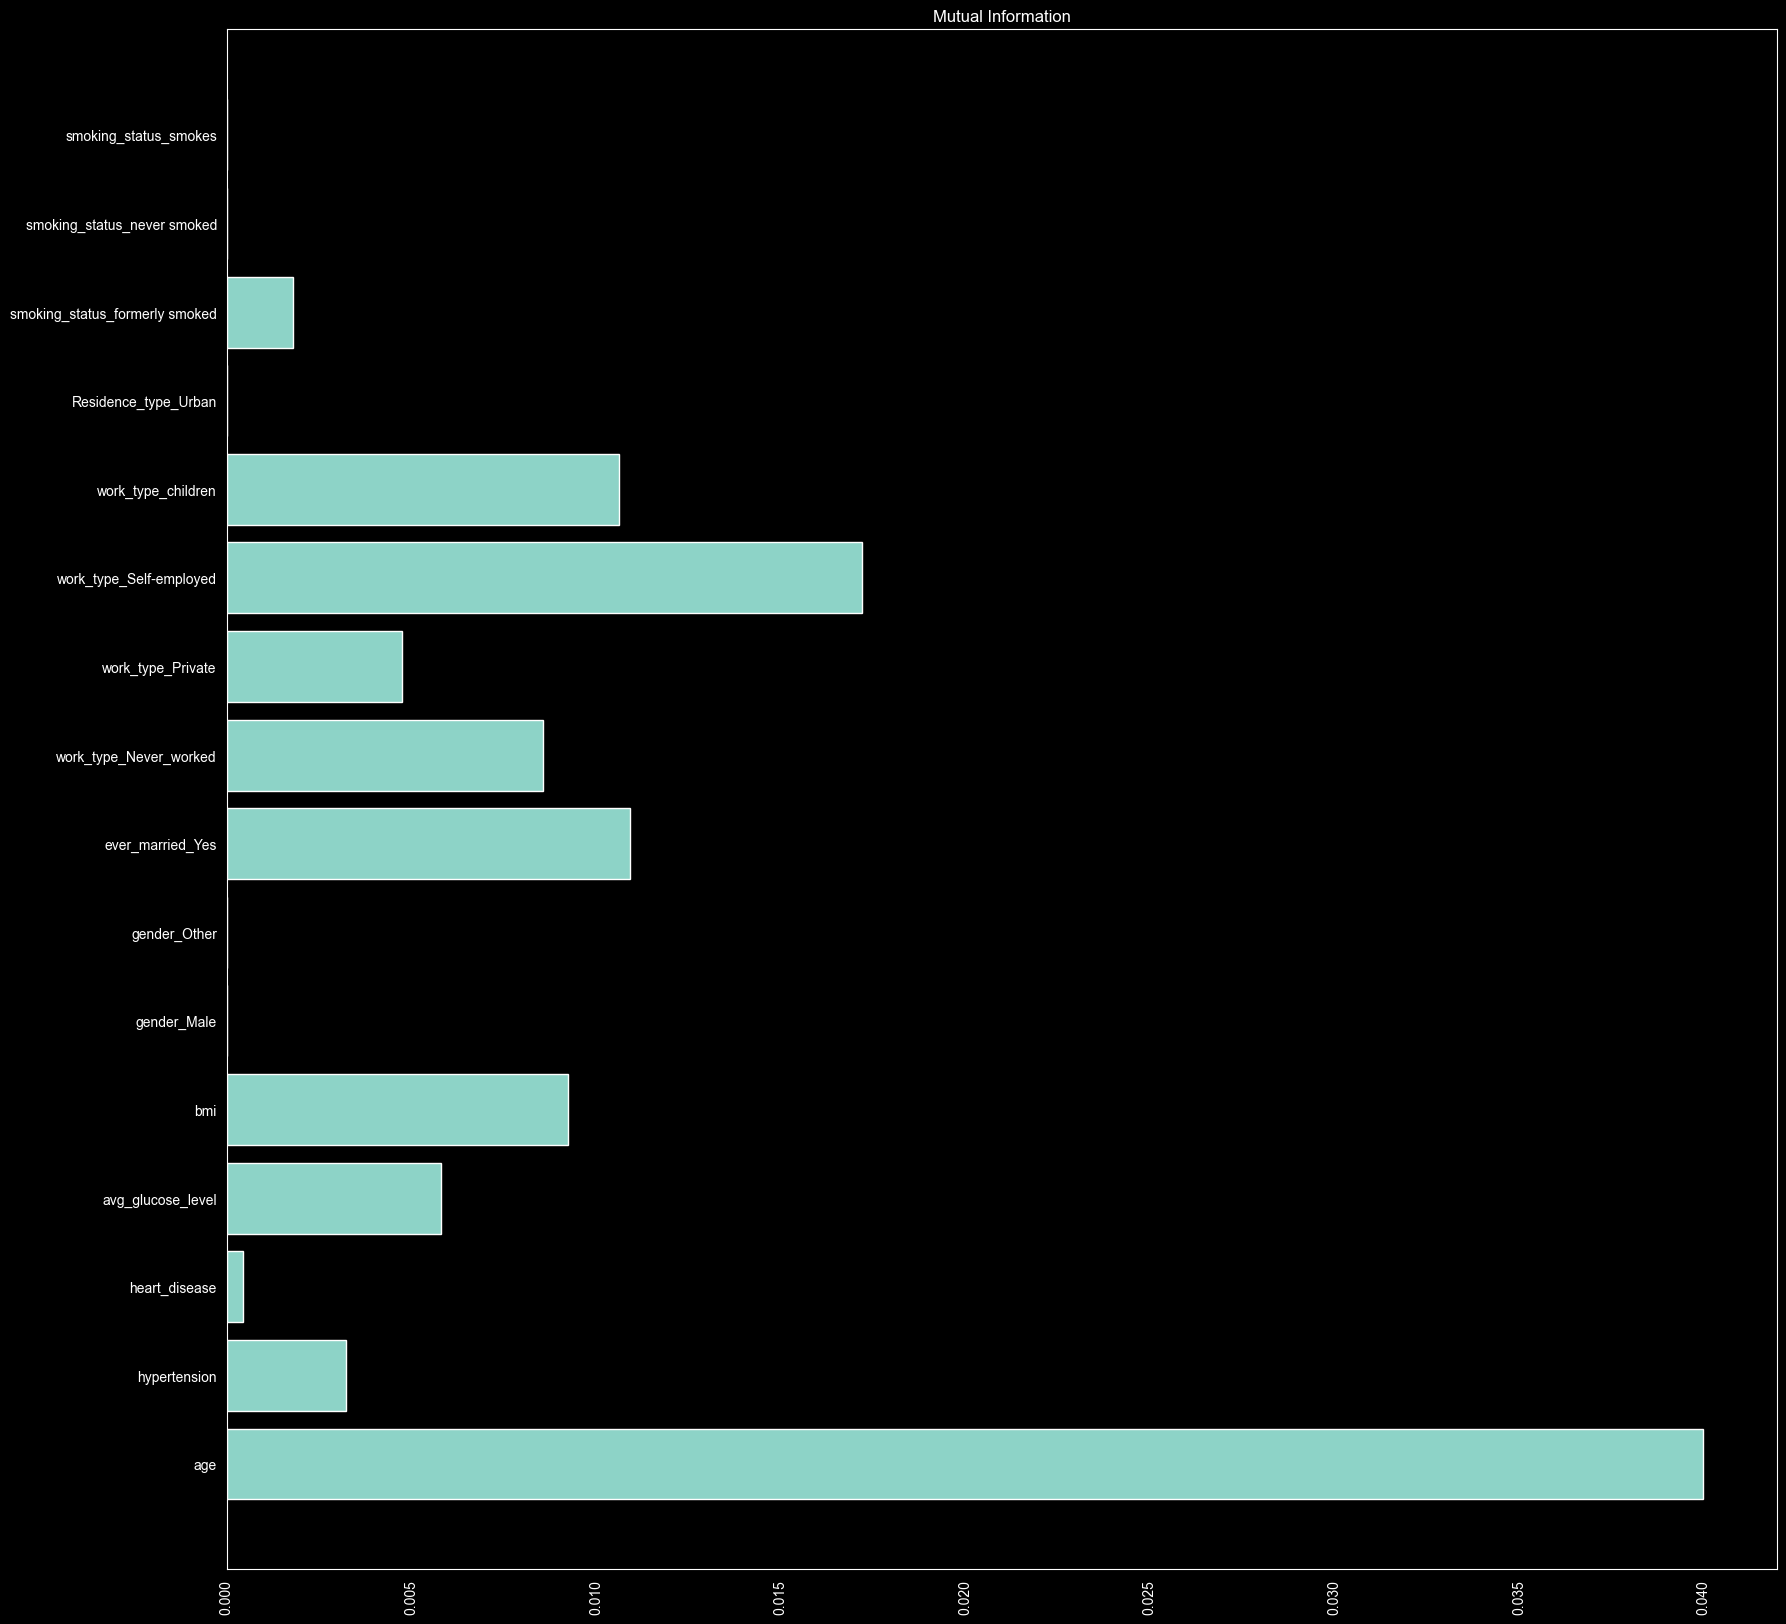

,Feature,Mutual Information
0,age,0.039972
1,hypertension,0.003237
2,heart_disease,0.000445
3,avg_glucose_level,0.005812
4,bmi,0.009246
5,gender_Male,0.000000
6,gender_Other,0.000000
7,ever_married_Yes,0.010913
8,work_type_Never_worked,0.008569
9,work_type_Private,0.004756


In [18]:
sample_idx = np.random.choice(len(X_train), size=int(X_train.size/20), replace=False)

mi = mutual_info_regression(X_train.iloc[sample_idx], y_train.iloc[sample_idx])
mi_df = pd.DataFrame({"Feature": X_train.columns, "Mutual Information": mi})

plt.figure(figsize=(20, 20))
plt.barh(X_train.columns, mi)
plt.grid(False)
plt.xticks(rotation=90)
plt.title('Mutual Information')
plt.show()
mi_df



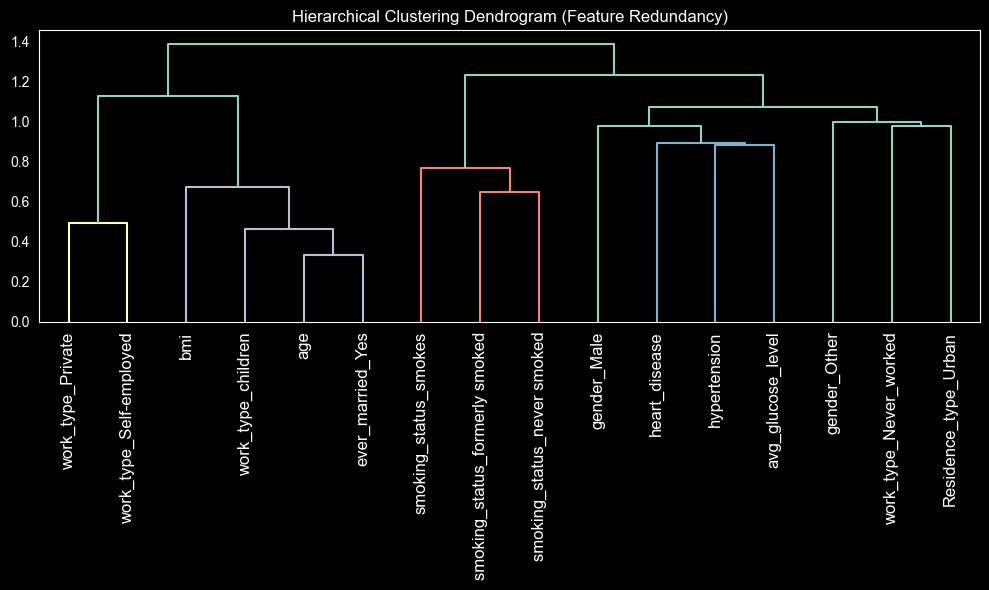

Original features: 16
Reduced features: 5
Selected: Index(['age', 'hypertension', 'gender_Other', 'work_type_Private',
       'smoking_status_formerly smoked'],
      dtype='object')


In [19]:
names = X_train.columns
# 1. Compute Spearman correlation and distance matrix
# Assuming X is your dataframe of explanatory variables
corr = spearmanr(X).correlation
# Ensure the matrix is symmetric (sometimes float errors occur)
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# Convert correlation to a distance matrix
dist_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(hierarchy.distance.squareform(dist_matrix))

# 2. Visualize the Dendrogram
fig, ax = plt.subplots(figsize=(10, 6))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=names, ax=ax, leaf_rotation=90
)
ax.set_title("Hierarchical Clustering Dendrogram (Feature Redundancy)")
plt.tight_layout()
plt.grid(False)
plt.show()

# 3. Select Features
# Threshold '1' is common for 1 - abs(corr), but you can adjust based on the plot
cluster_ids = hierarchy.fcluster(dist_linkage, t=1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)

# Keep only the first feature from each cluster
selected_idx = [v[0] for v in cluster_id_to_feature_ids.values()]
mi_features = names[selected_idx]
X_reduced = X_train.iloc[:, selected_idx]


print(f"Original features: {X_train.shape[1]}")
print(f"Reduced features: {len(mi_features)}")
print(f"Selected: {mi_features}")

In [20]:
def calculate_vif(df: pd.DataFrame):
    vif_data = pd.DataFrame()
    vif_data["feature"] = df.columns

    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(len(df.columns))]
    print(vif_data)

In [21]:
calculate_vif(X_train.drop(columns=["age", "bmi"]))
vif_features = X_train.drop(columns=["age", "bmi"]).columns.tolist()
vif_features

                           feature       VIF
0                     hypertension  1.184602
1                    heart_disease  1.117210
2                avg_glucose_level  5.577768
3                      gender_Male  1.710159
4                     gender_Other  1.003274
5                 ever_married_Yes  3.749587
6           work_type_Never_worked  1.033505
7                work_type_Private  3.564256
8          work_type_Self-employed  1.844817
9               work_type_children  1.594054
10            Residence_type_Urban  1.937470
11  smoking_status_formerly smoked  1.783901
12     smoking_status_never smoked  2.435212
13           smoking_status_smokes  1.651272


['hypertension',
 'heart_disease',
 'avg_glucose_level',
 'gender_Male',
 'gender_Other',
 'ever_married_Yes',
 'work_type_Never_worked',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

In [22]:
model = LogisticRegression(
    solver="lbfgs",
    max_iter=10000,
    class_weight="balanced",
    random_state=42
)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=StratifiedKFold(5),
    scoring="roc_auc",
    min_features_to_select=3
)

rfecv.fit(X_train_scaled, y_train)

rfe_features = X_train.columns[rfecv.support_].tolist()
ranking = pd.DataFrame({
    "feature": X_train.columns,
    "rank": rfecv.ranking_
}).sort_values("rank")

print("Liczba wybranych cech:", len(rfe_features))
print("Wybrane cechy:")
print(rfe_features)

Liczba wybranych cech: 4
Wybrane cechy:
['age', 'avg_glucose_level', 'work_type_Never_worked', 'work_type_children']


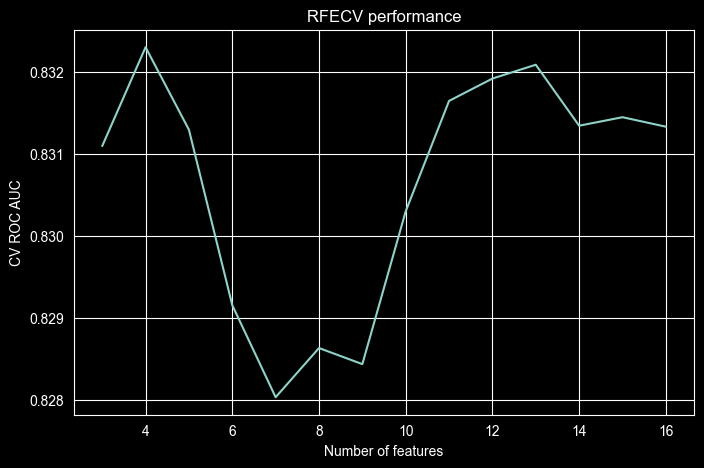

In [23]:
plt.figure(figsize=(8, 5))
plt.plot(
    range(rfecv.min_features_to_select, len(rfecv.cv_results_["mean_test_score"]) + rfecv.min_features_to_select),
    rfecv.cv_results_["mean_test_score"]
)
plt.xlabel("Number of features")
plt.ylabel("CV ROC AUC")
plt.title("RFECV performance")
plt.grid(True)
plt.show()


## Chosen features lists

In [24]:
## hard coding because of stochasticity

all_features = ["age", "hypertension", "heart_disease", "avg_glucose_level",
                "bmi", "gender_Male", "gender_Other", "ever_married_Yes",
                "work_type_Never_worked", "work_type_Private", "work_type_Self-employed",
                "work_type_children", "Residence_type_Urban",
                "smoking_status_formerly smoked", "smoking_status_never smoked",
                "smoking_status_smokes"]

boruta_features = ["age", "avg_glucose_level", "bmi"]

corr_features = ["age", "heart_disease", "avg_glucose_level", "hypertension",
                 "ever_married_Yes", "smoking_status_formerly smoked",
                 "work_type_Self-employed"]

mi_features = ["age", "hypertension", "gender_Other",
               "work_type_Private", "smoking_status_formerly smoked"]

rfe_features = ["age", "hypertension", "heart_disease", "avg_glucose_level",
                "bmi", "work_type_Never_worked", "work_type_children",
                "Residence_type_Urban", "smoking_status_never smoked",
                "smoking_status_smokes"]

FEATURE_SETS = {
    "all": all_features,
    "boruta": boruta_features,
    "correlation": corr_features,
    "mi": mi_features,
    "rfe": rfe_features
}